In [251]:
import pandas as pd
from hydra import initialize, compose
from pathlib import Path
from ergochemics.draw import draw_reaction, draw_molecule
from ergochemics.mapping import rc_to_nest
from IPython.display import SVG
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np

In [252]:
def draw_reactants_mech_rc_labeled(smarts: str, rc: tuple[tuple[tuple[int]]], mech_atoms: tuple[tuple[tuple[int]]], entry_id: int, size: tuple[int, int] = (250, 150), highlight_color: tuple = (0.75, 0.6, 0.75), save_to: Path = None):
    _draw_opts = {
        'useBWAtomPalette': None,
        'setHighlightColour': highlight_color,
        'annotationFontScale': 0.77,
    }
    denom = 100
    scl_size = lambda size, n_atoms: (int(size[0] * (1 + n_atoms / denom)), int(size[1] * (1 + n_atoms / denom)))

    if save_to is not None:
        (save_to / f"mcsa_{entry_id}").mkdir(parents=True, exist_ok=True)

    rcts, pdts = [[Chem.MolFromSmiles(smi) for smi in side.split('.')] for side in smarts.split(">>")]

    for i, rct, rct_rc, rct_ma in zip(range(len(rcts)), rcts, rc[0], mech_atoms[0]):
        for maidx in rct_ma:
            atom = rct.GetAtomWithIdx(maidx)
            atom.SetProp('atomNote', 'M')

        for rcidx in rct_rc:
            atom = rct.GetAtomWithIdx(rcidx)
            atom.SetProp('atomNote', 'RC')

        _size = scl_size(size, rct.GetNumAtoms())
        hatoms = list(set(rct_rc) | set(rct_ma))
        img = draw_molecule(
                    rct,
                    size=_size,
                    highlight_atoms=hatoms,
                    draw_options=_draw_opts
                )
        display(SVG(img))

        if save_to is not None:
            img_path = save_to / f"mcsa_{entry_id}" / f"rct_{i}.svg"
            with open(img_path, 'w') as f:
                f.write(img)

    for i, pdt, pdt_rc, pdt_ma in zip(range(len(rcts)), pdts, rc[1], mech_atoms[1]):
        for maidx in pdt_ma:
            atom = pdt.GetAtomWithIdx(maidx)
            atom.SetProp('atomNote', 'M')

        for rcidx in pdt_rc:
            atom = pdt.GetAtomWithIdx(rcidx)
            atom.SetProp('atomNote', 'RC')

        _size = scl_size(size, pdt.GetNumAtoms())
        hatoms = list(set(pdt_rc) | set(pdt_ma))
        img = draw_molecule(
            pdt,
            size=_size,
            highlight_atoms=hatoms,
            draw_options=_draw_opts
        )
        display(SVG(img))

        if save_to is not None:
            img_path = save_to / f"mcsa_{entry_id}" / f"pdt_{i}.svg"
            with open(img_path, 'w') as f:
                f.write(img)

In [253]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

In [254]:
mm = pd.read_parquet(
    Path(cfg.raw_data) / "distilled_mech_reactions.parquet"
)
mm["mech_atoms"] = mm["mech_atoms"].apply(rc_to_nest)
mm["reaction_center"] = mm["reaction_center"].apply(rc_to_nest)
mm.head()

,entry_id,mechanism_id,smarts,am_smarts,reaction_center,mech_atoms,enzyme_name,uniprot_id,ec,reported_direction
0,1,1,NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O,[NH2:26][CH:25]([CH2:27][CH2:31][C:28](=[O:29]...,"(((7, 8, 9),), ((7, 8, 9),))","(((1,),), ((1,),))",glutamate racemase,P56868,5.1.1.3,True
1,1,1,NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O,[NH2:26][CH:25]([CH2:27][CH2:31][C:28](=[O:29]...,"(((7, 8, 9),), ((7, 8, 9),))","(((1,),), ((1,),))",glutamate racemase,P56868,5.1.1.3,False
2,2,2,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:33][C:32](=[O:35])[NH:30][CH:16]1[C:17](=[O...,"(((5, 7), (0,)), ((5, 7, 9),))","(((6,), ()), ((6,),))",beta-lactamase (Class A),P62593,3.5.2.6,True
3,2,2,*C(=O)NC(C(=O)O)C1NC(C(=O)O)C(C)(C)S1>>*C(=O)N...,[*:33][C:32](=[O:35])[NH:30][CH:16]([C:17](=[O...,"(((5, 7, 9),), ((5, 7), (0,)))","(((6,),), ((6,), ()))",beta-lactamase (Class A),P62593,3.5.2.6,False
4,2,1,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:51][C:50](=[O:52])[NH:48][CH:33]1[C:35](=[O...,"(((5, 7), (0,)), ((5, 7, 9),))","(((6,), ()), ((6,),))",beta-lactamase (Class A),P62593,3.5.2.6,True


In [255]:
entries = [
    21,
    59,
    61,
    65,
    73,
    741,
    759,
    846,
    874,
    899,
    933,
    963,
    1003,
]

Entry ID: 21


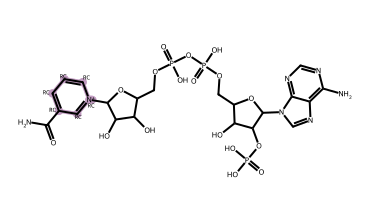

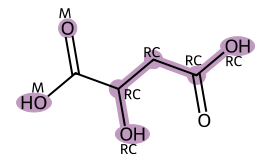

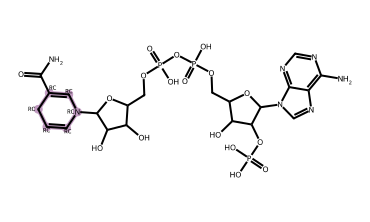

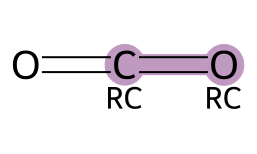

Entry ID: 59


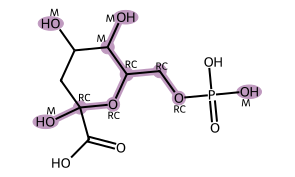

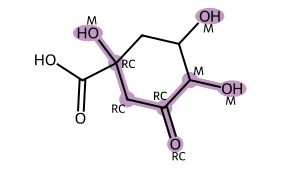

Entry ID: 61


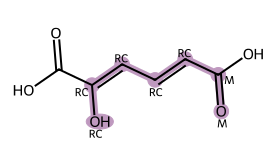

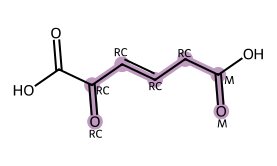

Entry ID: 65


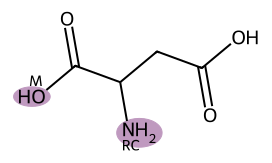

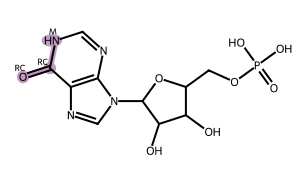

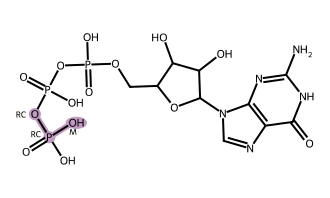

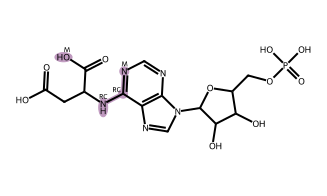

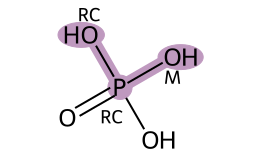

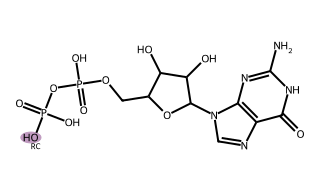

Entry ID: 73


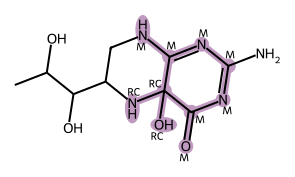

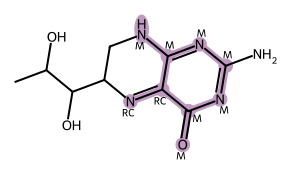

Entry ID: 741


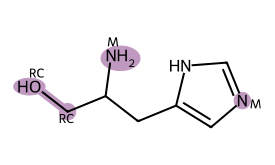

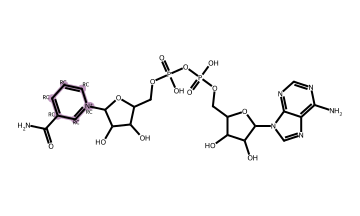

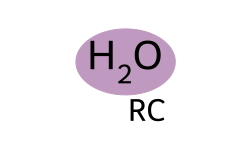

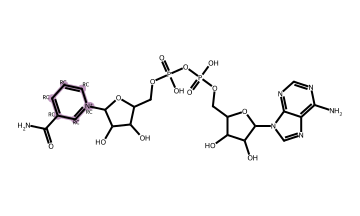

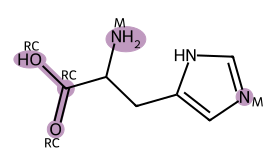

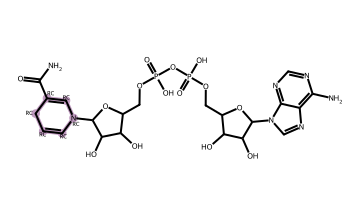

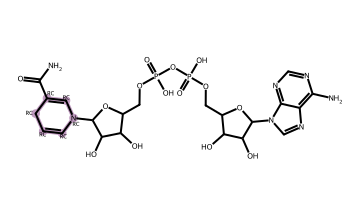

Entry ID: 759


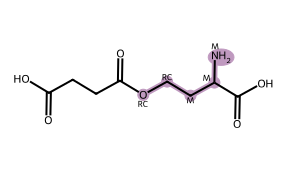

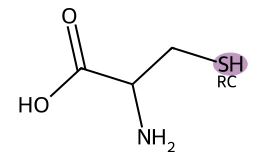

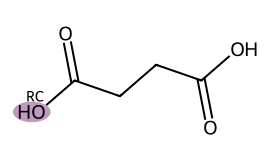

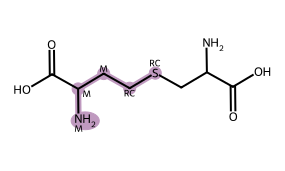

Entry ID: 846


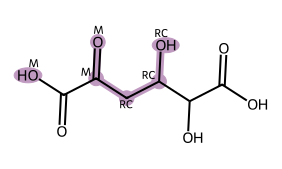

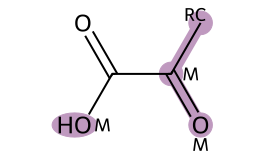

Entry ID: 874


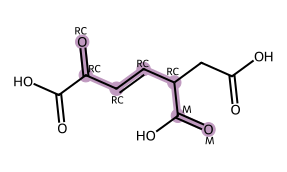

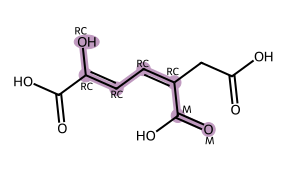

Entry ID: 899


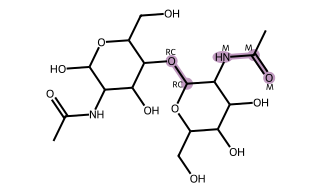

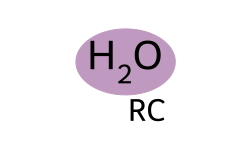

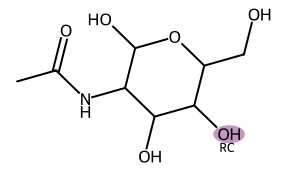

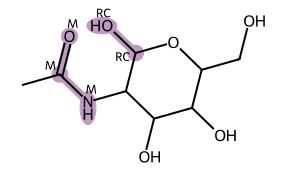

Entry ID: 933


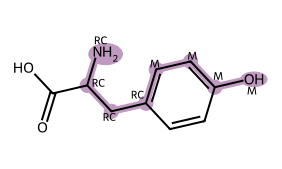

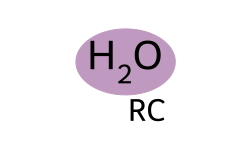

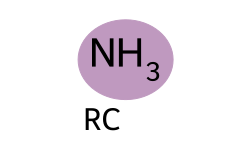

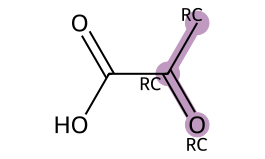

Entry ID: 963


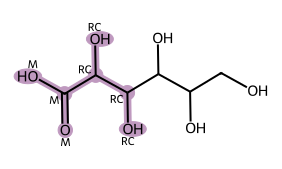

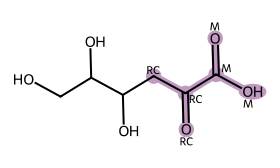

Entry ID: 1003


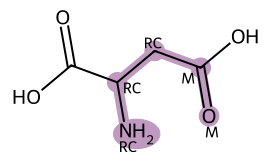

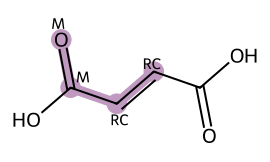

In [256]:
for entry in entries:
    row = mm.loc[mm['entry_id'] == entry].iloc[0]
    rc = row["reaction_center"]
    mech_atoms = row["mech_atoms"]
    smarts = row["smarts"]
    print(f"Entry ID: {entry}")
    draw_reactants_mech_rc_labeled(smarts, rc, mech_atoms, entry, save_to=Path(cfg.artifacts) / "figures" / "illustrative_mechinfo_templates")